# Blendle timeline - Machine Geleerden

### Authors: Bram Veenman, Bram Slangen, Emma Quist, David Borensztajn
Please mail us if you want to use this notebook: davidborensztajn@gmail.com

The idea behind this project is to use the news article database that Blendle has gathered over the years to build a topic organization algorithm. That is, a tool that is able to gather articles about a certain topic. Furthermore, this algorithm should use machine learning to extract important events that happened with regards to this topic. Lastly, these events should be presented on a topic timeline.

# Importing libraries

In [20]:
# installations needed: pandas, numpy, beautifulsoup, nltk (and modules), sklearn, gensim, matplotlib
import json
import pandas as pd
import numpy as np
import string, re, nltk
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
import requests
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import gensim
from gensim.summarization import summarize
import ast
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from textwrap import wrap


# Pre-processing articles


This section loads the json dataset and cleans the data by removing irrelevant words and punctuation. It then stores the pre-processed articles in a json file.


### Functions

In [4]:
# loads json file
def open_json(filepath):
    articles = []
    file = open(filepath)
    i = 0
    for article in file:
        articles.append(json.loads(article))
        if i == 10000:
            break
        i+= 1
    file.close()
    return articles


# unpack body into title, intro and text
def unpack_bodies(bodies):
    intros = [next((sec["content"] for sec in body if sec["type"]=="intro"), None) for body in bodies]
    headers = [next((sec["content"] for sec in body if sec["type"]=="hl1"), None) for body in bodies]
    paragraphs = [" ".join([sec["content"] for sec in body if sec["type"] == "p"]) for body in bodies]
    return intros, headers, paragraphs


# removes html and punctuation and converts to lowercase
def remove_html_punct(text):
    # remove html tags
    if text:
        text = BeautifulSoup(text,features="html.parser").get_text()
        # remove punctuation
        punc = string.punctuation + "“”‘’—"
        no_punct = [words for words in text if words not in punc]
        words_wo_punct=''.join(no_punct)
        return words_wo_punct.lower()

# text tokenization
def tokenize(text):
    return nltk.tokenize.word_tokenize(text)

# removes meaningless common words
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

# reduces words to their lemma
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# function removes too long intros
def remove_long_intros(df, max=100, col="intro"):
    df.loc[:,col] = df.loc[:,col].str[:max]
    return df

### Script

In [5]:
# load data with open_json function
articles = open_json("../articles_en_2020_raw.json")

# get dates and bodies for each article
ids = [article["id"] for article in articles]
dates = [article["date"] for article in articles]
bodies = [article["body"] for article in articles]

# unpack body into title, intro and text
intros, headers, pars = unpack_bodies(bodies)

# put articles into pandas dataframe
df = pd.DataFrame({"id":ids, "date":dates, "header":headers, "intro":intros, "text": pars})

df.to_json("../dataframe_20_no_pre.json")

# fill empty cells with string
df = df.fillna("empty")
df = df.replace("","empty")


# find articles that have an intro
has_intro = df["intro"].apply(lambda x: x != "empty")

if df.loc[~has_intro].items():
    columns = ["header","intro","text"]
    # apply preprocessing functions to articles w/o intros: 
    # remove html tags, punctuation and convert to lowercase
    # tokenize
    # remove stopwords
    for col in columns:
        df[col] = [lemmatizing(remove_stopwords(tokenize(remove_html_punct(x)))) for x in df[col]]
    # articles without intro get first 20 words from main text as intro
    df.loc[~has_intro,"intro"] = df.loc[~has_intro,"text"[:20]]
    df = df.drop("text", axis=1)
else:
    # apply preprocessing functions to articles with intros: 
    # remove html tags, punctuation and convert to lowercase
    # tokenize
    # remove stopwords
    columns = ["header","intro"]
    for col in columns:
        df[col] = [lemmatizing(remove_stopwords(tokenize(remove_html_punct(x)))) for x in df[col]]
        
# remove long intros from df
df = remove_long_intros(df)

# save pre-processed article dataset as json
df.to_json("../dataframe_20.json")

## Wikipedia keyword extraction

This section uses the wikipedia pages of the topics to find keywords for each topic.


### Functions

In [6]:
# retrieves page from url and cleans the text
def html2text(html):
    soup = BeautifulSoup(html, features="html.parser")
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()
        
    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())

    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    stop_words = set(stopwords.words("english"))

    # remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)

    # convert to lowercase
    text = text.lower()

    # remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    re.sub("(\\d|\\W)+"," ",text)

    # convert to list from string
    text = text.split()

    # add common wikipedia words to stopwords
    wiki_words = set(["archived", "retrieved", "original", "article", "edit", "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "pmid", "doi", "issn", "times", "tossup", "time"])
    stop_words= stop_words.union(wiki_words)
    
    # add custom stopwords
    custom_words = ["using", "show", "result", "large", "also", "iv", "one","two", "new", "previously", "shown", "mr", "yea", "nay"]
    stop_words = stop_words.union(set(custom_words))

    # lemmatizing and removing stopwords
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    return text

# finds n-grams (keywords) in text
def get_top_n_words(corpus, n, stop_words, ngram_range):
    if corpus == ["empty"]:
        return corpus
    vec = CountVectorizer(stop_words=stop_words, max_features=10000, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus) 
    words_freq = list(vec.vocabulary_.keys())
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                    reverse=True)
    return words_freq[:n]

### Script

##### Loads and pre-processes wikipedia pages and stores  in text file for each topic

In [7]:
# Wikipedia urls
urls = {"covid":"https://en.wikipedia.org/wiki/Coronavirus_disease_2019",
"blm":"https://en.wikipedia.org/wiki/Black_Lives_Matter",
"bxt":"https://en.wikipedia.org/wiki/Brexit",
"impeach": "https://en.wikipedia.org/wiki/First_impeachment_of_Donald_Trump", "elections": "https://en.wikipedia.org/wiki/2020_United_States_presidential_election"}

# apply function
for topic, url in urls.items():
    # get text from urls
    request = requests.get(url)
    text = html2text(request.text)

    # add text to file
    file = open(f"../wiki_{topic}.txt","w")
    file.write(text)
    file.close()

##### Takes wikipedia text files and finds the most common keywords (n-grams)

In [8]:
# set of english stopwords
stop_words = set(stopwords.words("english"))

# create topic df
topics = ["covid","blm","bxt","impeach", "elections"]
wiki_df = pd.DataFrame(data={"all_words":" "},index=topics)

# add wikipedia words to df
file_contents = []
for topic in topics:
    file = open(f"../wiki_{topic}.txt","r")
    content = file.readlines()
    file_contents.append(content)

# find most occuring n grams and put in df
wiki_df["all_words"] = file_contents
n = 5
for i in range(1,4):
    wiki_df[f"top_{str(i)}"] = [get_top_n_words(x, n, stop_words, (i,i)) for x in wiki_df["all_words"]]
    wiki_df[f"top_{str(i)}"] = [[word for word,freq in tuple] for tuple in wiki_df[f"top_{str(i)}"]]

# save dataframe as json file
wiki_df.to_json("../wiki_df.json")

# save dataframe as csv file
wiki_df.to_csv("../wiki_df.csv")
    

## Topic filtering

This section filters the article dataset using similarity matching with the topic keywords. The output is a topic-specific json file containing the articles that belong to that topic. 


### Functions

In [9]:
# filters relevant articles
def filter_topic(df,search_terms, thresh):
    filter = []
    terms_list = []
    # loop through articles
    for header, intro in zip(df["header"],df["intro"]):
        word_list = header + intro
        article_terms = []
        score = 0
        # loop through words in article
        for word1, word2, word3 in zip(word_list,word_list[1:],word_list[2:]):            
            # single words
            for term in search_terms[1]:
                if word1 == term:
                    if term not in article_terms:
                        score += 1
                        article_terms.append(term)
            # 2 words
            for term1, term2 in search_terms[2]:
                if term1 == word1 and term2 == word2: 
                    if (term1,term2) not in article_terms:
                        score += 2
                        article_terms.append((term1,term2))
            # 3 words
            for term1, term2, term3 in search_terms[3]:
                if term1 == word1 and term2 == word2 and term3 == word3:
                    if (term1,term2,term3) not in article_terms:
                        score += 2
                        article_terms.append((term1,term2,term3))
        if article_terms == []:
            article_terms.append(score)
            article_terms.append(None)
        # keep articles with sufficiently high score
        filter.append(score >= thresh)
        #if score > thresh: print(score)
        terms_list.append(article_terms)
    df["terms"] = terms_list
    return df[filter]




### Script

In [10]:
import pandas as pd

# load data
# df = pd.read_json("../dataframe_20.json")
wiki_df = pd.read_json("../wiki_df.json")


# load wikipedia keywords
covid_terms = {1:wiki_df.loc["covid","top_1"],
                2:[x.split(" ") for x in wiki_df.loc["covid","top_2"]],
                3:[x.split(" ") for x in wiki_df.loc["covid","top_3"]]}

bxt_terms = {1:wiki_df.loc["bxt","top_1"],
                2:[x.split(" ") for x in wiki_df.loc["bxt","top_2"]],
                3:[x.split(" ") for x in wiki_df.loc["bxt","top_3"]]}

blm_terms = {1:wiki_df.loc["blm","top_1"],
                2:[x.split(" ") for x in wiki_df.loc["blm","top_2"]],
                3:[x.split(" ") for x in wiki_df.loc["blm","top_3"]]}

impeach_terms = {1:wiki_df.loc["impeach","top_1"],
                2:[x.split(" ") for x in wiki_df.loc["impeach","top_2"]],
                3:[x.split(" ") for x in wiki_df.loc["impeach","top_3"]]}

elections_terms = {1:wiki_df.loc["elections","top_1"],
                2:[x.split(" ") for x in wiki_df.loc["elections","top_2"]],
                3:[x.split(" ") for x in wiki_df.loc["elections","top_3"]]}




# manually change keywords
covid_terms[2][2] = ["global","pandemic"]

bxt_terms[2][0] = ["transition","period"]
bxt_terms[3][0] = ["withdraw","united","kingdom"]
del bxt_terms[3][1:]

blm_terms[1][3] = "floyd"
blm_terms[1][4] = "breonna"
blm_terms[2][2] = ["george","floyd"]
blm_terms[2][3] = ["breonna","taylor"]
blm_terms[2][4] = ["movement","black"]

impeach_terms[1][0] = "trial"
impeach_terms[1][4] = "committee"
impeach_terms[2][2] = ["trump", "trial"]
impeach_terms[2][4] = ["impeachment", "trump"]
impeach_terms[2][0] = ["impeachment", "committee"]
impeach_terms[1][2] = "impeached"
del impeach_terms[1][3]
del impeach_terms[2][3]

elections_terms[2][4] = ["republican", "vote"]
elections_terms[2][0] = ["joe", "biden"]
del elections_terms[1][1]
del elections_terms[2][3]

# filter articles
thresh = 3

# create dataframes
df_covid = filter_topic(df, covid_terms, thresh)
df_bxt = filter_topic(df, bxt_terms, thresh)
df_blm = filter_topic(df, blm_terms, thresh)
df_impeach = filter_topic(df, impeach_terms, thresh)
df_elections = filter_topic(df, elections_terms, thresh)

df_covid.to_json("../df_covid.json")
df_bxt.to_json("../df_bxt.json")
df_blm.to_json("../df_blm.json")
df_impeach.to_json("../df_impeach.json")
df_elections.to_json("../df_elections.json")

df_covid.to_csv("../df_covid.csv")
df_bxt.to_csv("../df_bxt.csv")
df_blm.to_csv("../df_blm.csv")
df_impeach.to_csv("../df_impeach.csv")
df_elections.to_csv("../df_elections.csv")

## Event clustering






### Functions

In [11]:
def check_onedate(cluster):
    if len(cluster.date.value_counts()) == 1:
        return 1
    else:
        return 0
    
# uses dbscan on all epsilon values till 1. It runs DBscan for each epsilon. Then it returns the epsilon that
# produces the highest % of single date clusters (so event clusters in which all articles are written on the same date)
def find_epsilon(name, df, vectors):
    eps_list = []
    percentage_list = []
    amount_single_list = []
    for i in np.arange(0.001, 1, 0.002):
        dbscan = DBSCAN(eps = i, min_samples=2, metric="cosine", ).fit(vectors)
        results_df = pd.DataFrame({"label":dbscan.labels_, "header":df["str_header"], "date":df["date"]})
        nr_clusters = len(pd.Series(dbscan.labels_).value_counts())
        clusters_df = results_df[results_df.label != -1]
        single_date_count = 0
        for cluster in range(nr_clusters - 1):
            c = clusters_df[clusters_df["label"] == cluster]
            single_date_count += check_onedate(c)
        percentage = single_date_count / (nr_clusters)
#         if len(pd.Series(dbscan.labels_).value_counts()) > 5:
        percentage_list.append(percentage)
        eps_list.append(i)
        amount_single_list.append(single_date_count / 100)
        
            
    plt.plot(eps_list, percentage_list, label="percentage of single_date")
    plt.plot(eps_list, amount_single_list, label="number of single_date")
    plt.xlabel("Epsilon")
    plt.ylabel("Clustering accuracy metric")
    plt.title(name) 

    plt.legend()
    plt.show()

    return eps_list[np.argmax(percentage_list)]


### Script

##### Finding event clusters for each topic

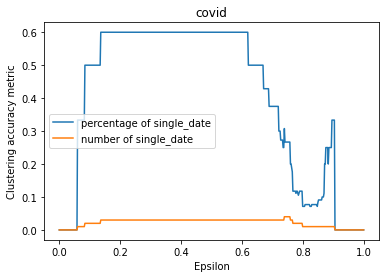

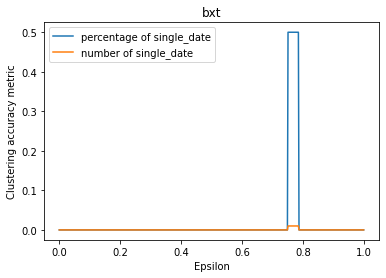

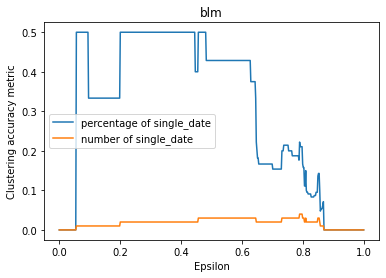

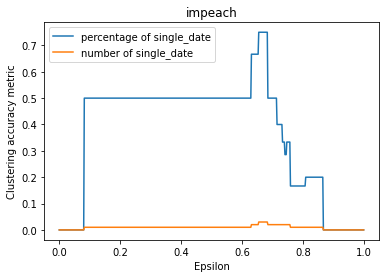

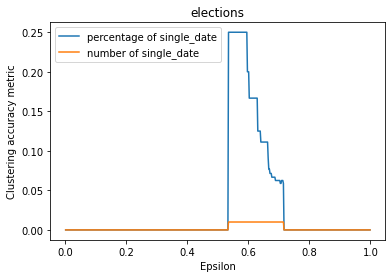

In [12]:
# load data
df_covid = pd.read_json("../df_covid.json")
df_bxt = pd.read_json("../df_bxt.json")
df_blm = pd.read_json("../df_blm.json")
df_impeach = pd.read_json("../df_impeach.json")
df_elections = pd.read_json("../df_elections.json")


# put all topic df in dictionairy
topics = {"covid": df_covid, "bxt": df_bxt, "blm": df_blm, "impeach": df_impeach, "elections": df_elections}

# clustering each topic and saving events to csv
for name, topic in topics.items():
    topic["str_header"] = [" ".join(x) for x in topic.header]
    topic["str_intro"] = [" ".join(x) for x in topic.intro]
    tfidf_vectorizer = TfidfVectorizer()
    topic.drop_duplicates(subset="str_header",keep=False,inplace=True)
    topic.drop_duplicates(subset="str_intro",keep="first",inplace=True)
    vectors = tfidf_vectorizer.fit_transform(topic["str_intro"]) #fit the vectorizer to synopses
    epsilon = find_epsilon(name, topic, vectors)
    dbscan = DBSCAN(eps = epsilon, min_samples=3, metric="cosine", ).fit(vectors)
    # if amount of events is smaller than 7, only require 2 articles for each event.
    if len(pd.Series(dbscan.labels_).value_counts()) < 7:
         dbscan = DBSCAN(eps = epsilon, min_samples=2, metric="cosine", ).fit(vectors)
    results_df = pd.DataFrame({"label":dbscan.labels_, "header":topic["str_header"], 
                               "date":topic["date"], "id":topic["id"]})
    results_df.to_csv(f"../{str(name)}_events.csv", index=False)
    


## Visualizing the timeline

### Functions

In [13]:
def summary(text, ratio):
    short_summary = summarize(text, word_count=50)
    return short_summary

In [18]:
# load clusters
df_covid = pd.read_csv("../covid_events.csv")
df_bxt =  pd.read_csv("../bxt_events.csv")
df_blm = pd.read_csv("../blm_events.csv")
df_impeach = pd.read_csv("../impeach_events.csv")
df_elections = pd.read_csv("../elections_events.csv")

topics = {"covid": df_covid, "bxt": df_bxt, "blm": df_blm, "impeach": df_impeach, "elections": df_elections}
full_df = pd.read_json("../dataframe_20_no_pre.json")
full_df = full_df.drop(["date"], axis=1)
full_df.columns = ["id", "full_header", "full_intro", "full_text"]

In [26]:
import textwrap
for name,clus in topics.items():
    clus = clus[clus["label"] > -1]
    clus = clus.sort_values(by=["label"])
    clus = clus.merge(full_df, how='left', on=['id'])
    if name == 'covid': 
        print("ai")
        clus.to_csv("covid_events_2.csv", index=False)
    clus = clus.groupby('label').agg(lambda x: x.loc[x.str.len().idxmax()])
    clus["sum"] = [summary(x, 50) for x in clus['full_text']]
    levels = np.ones(clus.shape[0])
    dates = clus['date']
    headers = clus['full_header']
    clus["sum"] = clus["sum"].apply(lambda t: "<br>".join(textwrap.wrap(t)))
    summas = clus["sum"]
    fig = px.scatter(clus, x='date', 
                     y=levels, 
                     title=name)
    fig.update_traces( hovertemplate=
                        "<b>%{x}</b><br><br>" +
                        "Header: %{customdata}<br>" +
                        "Summary: %{text}<br>" +
                        "<extra></extra>",
                        customdata=headers,text=summas
                        )
    
    
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(title="Dates",rangeslider_visible=True)
    fig.write_html(f"../{str(name)}_timeline.html")
    fig.show()

ai
